In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from geopy.distance import geodesic
import pickle


In [44]:
def geopy_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    coord1=(pickup_latitude,pickup_longitude)
    coord2=(dropoff_latitude, dropoff_longitude)
    return geodesic(coord1, coord2).kilometers
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def add_geographical_features(df, pickup_lat='pickup_latitude', pickup_lon='pickup_longitude',
                              dropoff_lat='dropoff_latitude', dropoff_lon='dropoff_longitude',
                              ):
    center_lat, center_lon = df[pickup_lat].median(), df[pickup_lon].median()
    df['pickup_center_dist'] = haversine(df[pickup_lat], df[pickup_lon],
                                         center_lat, center_lon)
    df['dropoff_center_dist'] = haversine(df[dropoff_lat], df[dropoff_lon],
                                          center_lat, center_lon)
    return df

In [45]:
def evaluate(model,x,y,message):
    y_p=model.predict(x)
    print(message+" MSE :",{mean_squared_error(y,y_p,squared=False)} ,"R2 :",r2_score(y,y_p))

In [46]:
root_dir = r'C:\Users\ahmed\Downloads\1 project-nyc-taxi-trip-duration\1 project-nyc-taxi-trip-duration'
train = pd.read_csv(os.path.join(root_dir, 'Data\split/train.csv'))
test = pd.read_csv(os.path.join(root_dir, 'Data\split/val.csv'))

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12620\3650244491.py:2: SyntaxWarning: invalid escape sequence '\s'
  train = pd.read_csv(os.path.join(root_dir, 'Data\split/train.csv'))
C:\Users\ahmed\AppData\Local\Temp\ipykernel_12620\3650244491.py:3: SyntaxWarning: invalid escape sequence '\s'
  test = pd.read_csv(os.path.join(root_dir, 'Data\split/val.csv'))


In [47]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,1.534793,1.665353,-73.973475,40.750947,-73.973421,40.751829,9.548850e+02
std,0.498788,1.315723,0.065404,0.033745,0.065432,0.035782,3.882070e+03
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,34.359695,1.000000e+00
25%,1.000000,1.000000,-73.991852,40.737372,-73.991341,40.735928,3.970000e+02
50%,2.000000,1.000000,-73.981728,40.754131,-73.979767,40.754551,6.620000e+02
75%,2.000000,2.000000,-73.967346,40.768379,-73.963036,40.769833,1.074000e+03
max,2.000000,7.000000,-61.335529,51.881084,-61.335529,43.921028,2.227612e+06


In [48]:
train.columns.values

array(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype=object)

In [49]:
def prepare(df):
    df=df.drop(columns=['id','store_and_fwd_flag'])
    df['log_trip_duration'] = np.log1p(df.trip_duration)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dayofweek'] = df.pickup_datetime.dt.dayofweek
    df['month'] = df.pickup_datetime.dt.month
    df['hour'] = df.pickup_datetime.dt.hour
    df['dayofyear'] = df.pickup_datetime.dt.dayofyear
    df["distance_km"] = df.apply(
        lambda row: geopy_distance(
            row["pickup_latitude"],
            row["pickup_longitude"],
            row["dropoff_latitude"],
            row["dropoff_longitude"]
        ),
        axis=1
    )
    df['distance_km']=np.log1p(df['distance_km'])
    df['distance_km_sqrt']=np.sqrt(df['distance_km'])
    df['distance_km_pw']=df['distance_km']**2

    df=add_geographical_features(df)
    df['pickup_center_dist']=np.log1p(df['pickup_center_dist'])
    df['dropoff_center_dist']=np.log1p(df['dropoff_center_dist'])

    df['is_weekend'] = df['dayofweek'].isin([5, 6])
    return df


In [50]:
test=prepare(test)
train=prepare(train)

In [51]:
train.columns.values

array(['vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'log_trip_duration',
       'dayofweek', 'month', 'hour', 'dayofyear', 'distance_km',
       'distance_km_sqrt', 'distance_km_pw', 'pickup_center_dist',
       'dropoff_center_dist', 'is_weekend'], dtype=object)

In [52]:
train.isna().sum()

vendor_id              0
pickup_datetime        0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
trip_duration          0
log_trip_duration      0
dayofweek              0
month                  0
hour                   0
dayofyear              0
distance_km            0
distance_km_sqrt       0
distance_km_pw         0
pickup_center_dist     0
dropoff_center_dist    0
is_weekend             0
dtype: int64

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   vendor_id            1000000 non-null  int64         
 1   pickup_datetime      1000000 non-null  datetime64[ns]
 2   passenger_count      1000000 non-null  int64         
 3   pickup_longitude     1000000 non-null  float64       
 4   pickup_latitude      1000000 non-null  float64       
 5   dropoff_longitude    1000000 non-null  float64       
 6   dropoff_latitude     1000000 non-null  float64       
 7   trip_duration        1000000 non-null  int64         
 8   log_trip_duration    1000000 non-null  float64       
 9   dayofweek            1000000 non-null  int32         
 10  month                1000000 non-null  int32         
 11  hour                 1000000 non-null  int32         
 12  dayofyear            1000000 non-null  int32         
 13

In [54]:
numeric_features = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
min_max=['distance_km','pickup_center_dist','dropoff_center_dist','distance_km_sqrt','distance_km_pw']
categorical_features = ['passenger_count','vendor_id','dayofweek', 'month', 'hour','dayofyear','is_weekend']

train_features = categorical_features + numeric_features + min_max

In [55]:
cloumn_transformer=ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),
    #('poly',PolynomialFeatures(degree=2),min_max),
    ('minmax',MinMaxScaler(),min_max),
    ('encoding',OneHotEncoder(handle_unknown="ignore"),categorical_features)
    ],
    remainder = 'passthrough'
)
model=Pipeline(steps=[
    ('preparation',cloumn_transformer),
    ('model',Ridge())
])

In [56]:
model.fit(train[train_features], train.log_trip_duration)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['distance_km',
                                                   'pickup_center_dist',
                                                   'dropoff_center_dist',
                                                   'distance_km_sqrt',
                                                   'distance_km_pw']),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['passenger_count',
                                                   'vendor_id', 'dayofweek',
                                                   'month', 'hour', 'dayofyear',
                                                   'is_weekend'])])),
                ('model', Ridge())])

In [57]:
evaluate(model,train[train_features],train.log_trip_duration,"train")
evaluate(model,test[train_features],test.log_trip_duration,"test")

C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train MSE : {0.4669089716126881} R2 : 0.654847775442874
train MSE : {0.47068068774791744} R2 : 0.653863067983933


C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


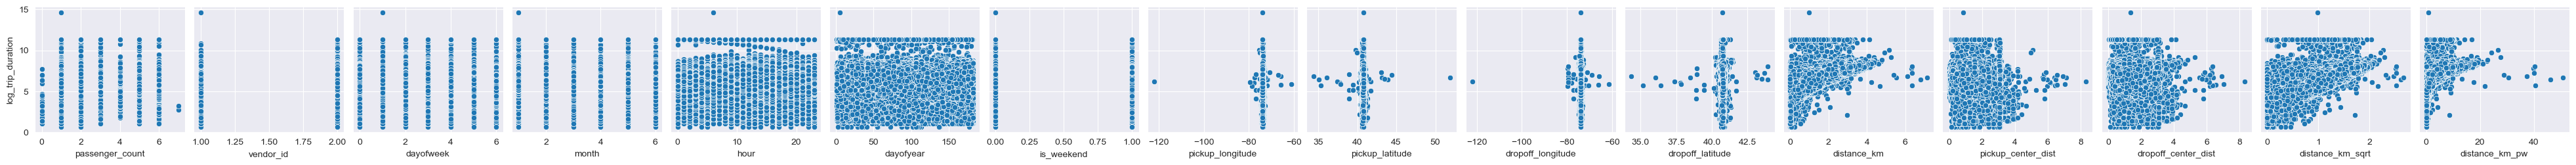

In [58]:
sns.pairplot(train,x_vars=train_features,y_vars=['log_trip_duration'])

<Axes: >

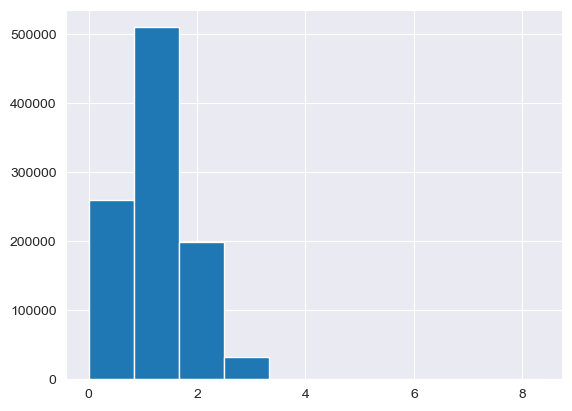

In [59]:
train['dropoff_center_dist'].hist()

<Axes: ylabel='distance_km'>

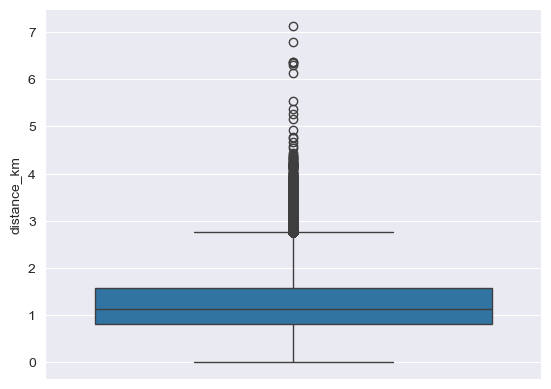

In [60]:
sns.boxplot(train['distance_km'])

In [61]:
train.columns.values


array(['vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'log_trip_duration',
       'dayofweek', 'month', 'hour', 'dayofyear', 'distance_km',
       'distance_km_sqrt', 'distance_km_pw', 'pickup_center_dist',
       'dropoff_center_dist', 'is_weekend'], dtype=object)

<Axes: >

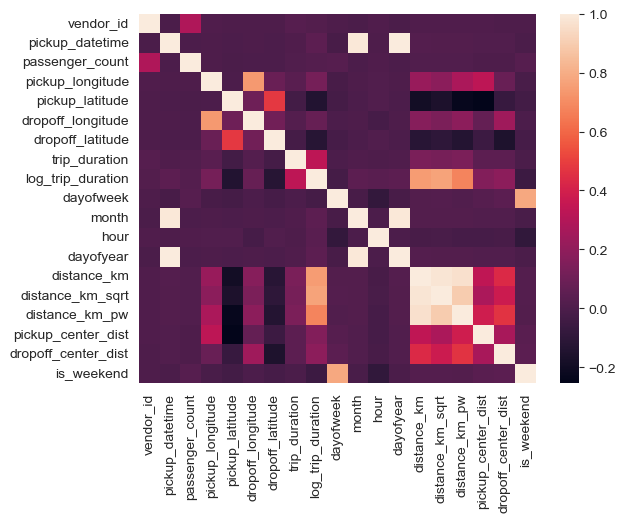

In [62]:
sns.heatmap(train.corr())

In [63]:
with open(os.path.join(root_dir,'Models/model.pkl'),"wb") as file:
    pickle.dump(model,file)
